# Capstone 2: Personality Prediction MBIT

## Proposal
Have you ever been curious about the personality type of yourself and people around 
you? Is there any simple test to help us find the answer without seeing a psychologist? The answer is yes. You can figure out your personality type by simply answering these four questions:

* Are you outwardly or inwardly focused ? 
* How do you prefer to take in information? 
* How do you prefer to make decisions? 
* How do you prefer to live your outer life?

For each question, there are two options to choose from. You choose the side that seems most  natural for you. The options are: Introversion (**I**) or Extraversion (**E**), Sensing (**S**) or Intuition (**N**), Thinking (**T**) or Feeling (**F**) and Judging (**J**) or Perception (**P**) respectively. The introspective self-report questionnaire we introduced above is known as Myers-Briggs -Type- Indicator (MBTI). It is a personality type system that divides everyone into 16 distinct personalities based one their answers to the previous questions. For example, someone who chooses extraversion, sensing, thinking and judging would be labeled an ESTP in the MBTI system. 

This project focuses on using machine learning algorithms to predict the personality of a person from the type of posts they put on social media. The data was collected through the PersonalityCare forum and is available on Kaggle [Personality Prediction Dataset](https://www.kaggle.com/datasnaek/mbti-type). This dataset consists of over 8600 rows representing 8675 different people and 2 columns representing a person’s MBTI personality type and the things they have posted.


## Exploratory Data Analysis

In [1]:
pip install pip --upgrade

     |████████████████████████████████| 1.5 MB 802 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2
    Uninstalling pip-20.2:
      Successfully uninstalled pip-20.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U gensim

Requirement already up-to-date: gensim in /opt/anaconda3/lib/python3.7/site-packages (3.8.3)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import numpy as np
import collections
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from gensim.corpora.dictionary import Dictionary
from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vnguyenair/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vnguyenair/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vnguyenair/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/vnguyenair/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
df = pd.read_csv('/Users/vnguyenair/Desktop/springboard/vy_capstone2_Personality_Prediction/mbti_1.csv',low_memory=False)
df.head()

type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...

The length of a post, number of questionmark, exclamation, ellipsis or images in a post might reveal the personality of the owner. We are going to add columns **post_length**, **question_per_post**, **excl_per_post**, **ellipsis_per_post**, **img_per_post**

In [5]:
df['post_length'] = df['posts'].apply(lambda x: len(x.split()))
df['question_per_post'] = df['posts'].apply(lambda x: x.count('?'))
df['img_per_post'] = df['posts'].apply(lambda x: x.count('jpg'))
df['excl_per_post'] = df['posts'].apply(lambda x: x.count('!'))
df['ellipsis_per_post'] = df['posts'].apply(lambda x: x.count('...'))

In [6]:
df.head()

type                                              posts  post_length  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...          556   
1  ENTP  'I'm finding the lack of me in these posts ver...         1170   
2  INTP  'Good one  _____   https://www.youtube.com/wat...          836   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...         1064   
4  ENTJ  'You're fired.|||That's another silly misconce...          967   

   question_per_post  img_per_post  excl_per_post  ellipsis_per_post  
0                 18             6              3                 15  
1                  5             1              0                 19  
2                 12             0              4                 13  
3                 11             0              3                 26  
4                 10             2              1                 21

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   type               8675 non-null   object
 1   posts              8675 non-null   object
 2   post_length        8675 non-null   int64 
 3   question_per_post  8675 non-null   int64 
 4   img_per_post       8675 non-null   int64 
 5   excl_per_post      8675 non-null   int64 
 6   ellipsis_per_post  8675 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 474.5+ KB


### Exploratory

We first want to explore the distribution of different kind of personality.

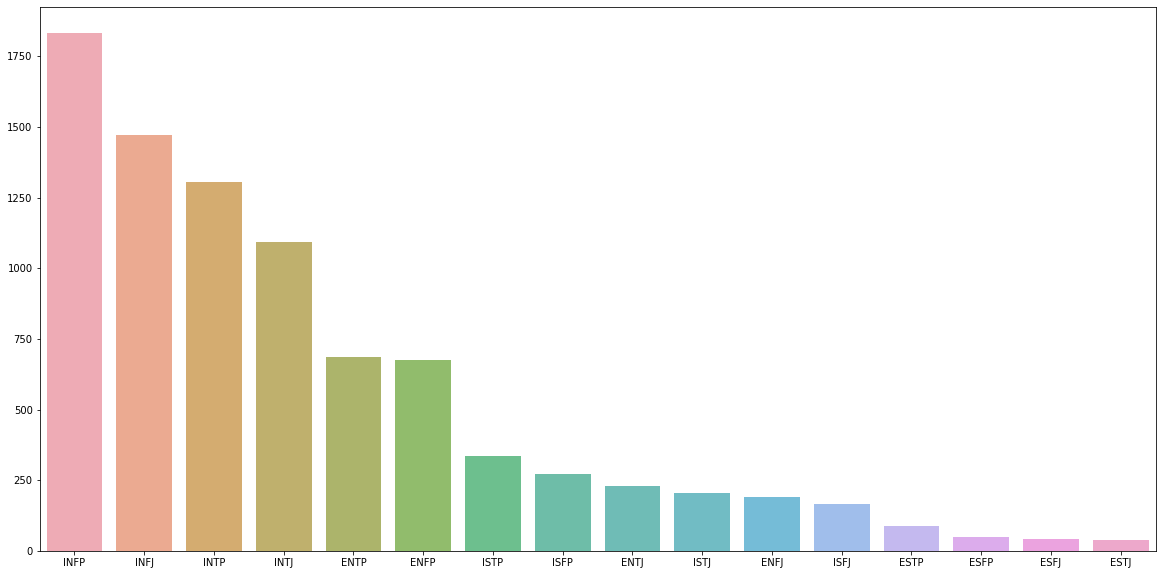

In [8]:
typ = df['type'].value_counts()

plt.figure(figsize=(20,10))
sns.barplot(typ.index, typ.values, alpha=0.8)

In [9]:
df[['type','posts']].groupby('type').count().sort_values(by='posts', ascending=False)

posts
type       
INFP   1832
INFJ   1470
INTP   1304
INTJ   1091
ENTP    685
ENFP    675
ISTP    337
ISFP    271
ENTJ    231
ISTJ    205
ENFJ    190
ISFJ    166
ESTP     89
ESFP     48
ESFJ     42
ESTJ     39

It is obvious that the distribution is unbalanced between different classes. The biggest class is **INFP** (Introversion-Intuition-Feeling-Perception) with 1832 people, while the smallest class is **ESTJ** (Extraversion-Sensing-Thinking-Judging) with only 39 people.

We now look at the relations between the type of personality and the length of post, as well as the number of questionmarks, exclamations, ellipsis and images per post.

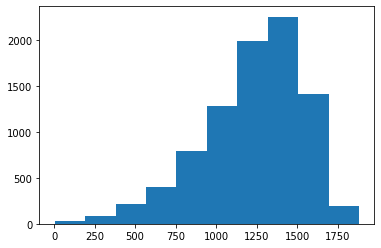

In [10]:
plt.hist(df['post_length'])
plt.show()

In [11]:
df[['type','post_length']].groupby('type').mean().sort_values(by='post_length', ascending=False)

post_length
type             
ESFJ  1290.476190
ENFJ  1286.584211
INFJ  1278.431973
ENFP  1260.770370
INFP  1244.552948
ISFJ  1241.295181
ESTJ  1229.538462
ENTJ  1218.086580
ISTJ  1213.224390
ENTP  1205.995620
INTP  1197.763037
INTJ  1194.577452
ISTP  1165.563798
ESTP  1162.595506
ISFP  1136.383764
ESFP  1022.125000

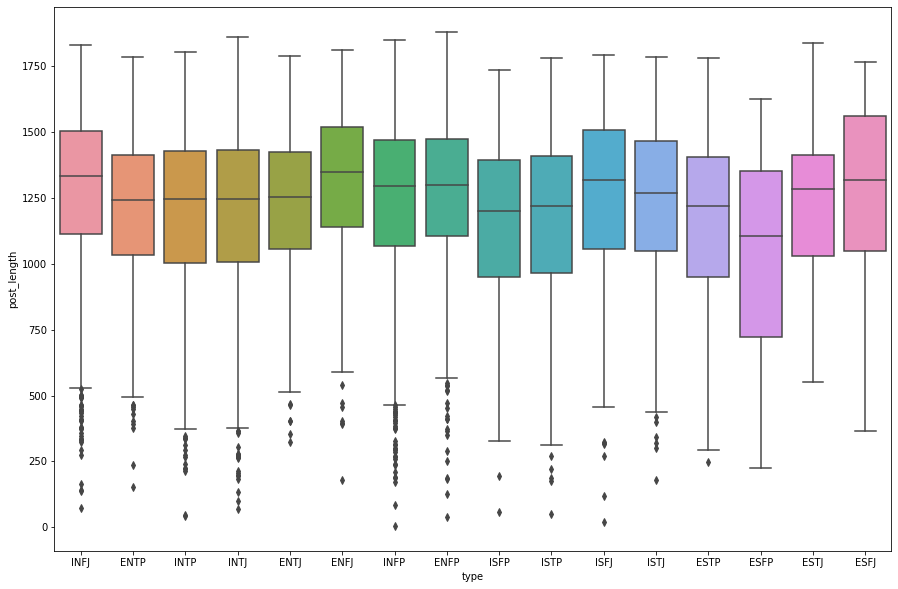

In [12]:
plt.figure(figsize=(15,10))
sns.boxplot("type", "post_length", data=df)

In [13]:
df[['type','question_per_post']].groupby('type').mean().sort_values(by='question_per_post', ascending=False)

question_per_post
type                   
ESTP          12.292135
ENTJ          12.000000
ESFP          11.854167
ENFP          11.362963
ISTP          11.080119
INTP          11.078988
ENTP          11.048175
ISFP          10.819188
ISTJ          10.746341
INTJ          10.742438
ENFJ          10.652632
ESTJ          10.487179
INFJ          10.448299
INFP          10.126638
ISFJ          10.048193
ESFJ           8.809524

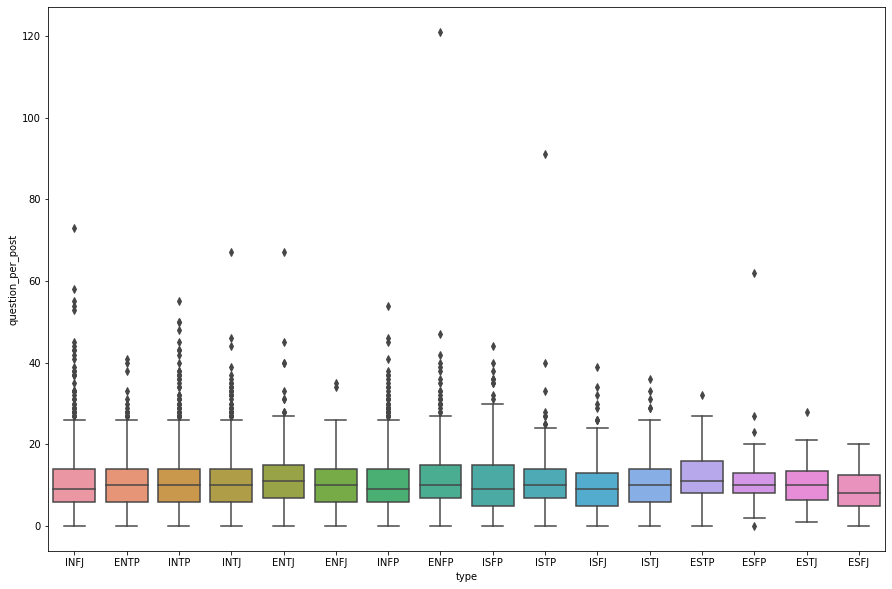

In [14]:
plt.figure(figsize=(15,10))
sns.boxplot("type", "question_per_post", data=df)

In [15]:
df[['type','excl_per_post']].groupby('type').mean().sort_values(by='excl_per_post', ascending=False)

excl_per_post
type               
ENFP      16.939259
ENFJ      13.800000
ESFJ      11.523810
ESFP      10.958333
ISFJ      10.475904
ISFP      10.398524
INFP       9.322052
INFJ       9.077551
ENTJ       8.298701
ESTJ       8.205128
ESTP       8.000000
ISTJ       7.980488
ENTP       7.129927
INTJ       5.262145
INTP       5.004601
ISTP       4.629080

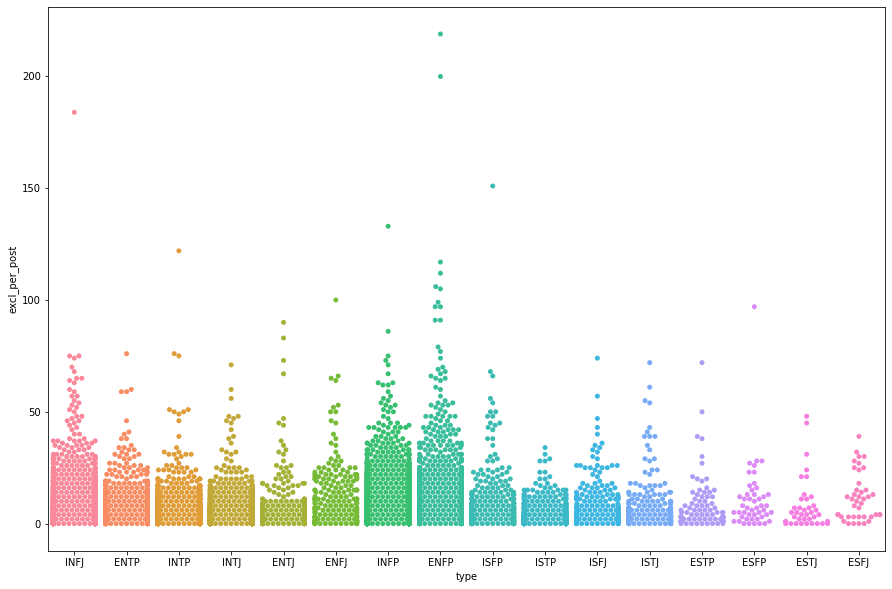

In [16]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "excl_per_post", data=df)

In [17]:
df[['type','ellipsis_per_post']].groupby('type').mean().sort_values(by='ellipsis_per_post', ascending=False)

ellipsis_per_post
type                   
ENFJ          37.221053
INFJ          36.071429
ENFP          35.794074
INFP          33.829694
ISFJ          33.072289
ENTJ          32.333333
ESFJ          31.928571
ISTJ          31.917073
INTP          31.608896
ENTP          31.551825
ESTJ          31.538462
INTJ          31.527039
ISFP          29.808118
ISTP          29.347181
ESTP          28.876404
ESFP          26.687500

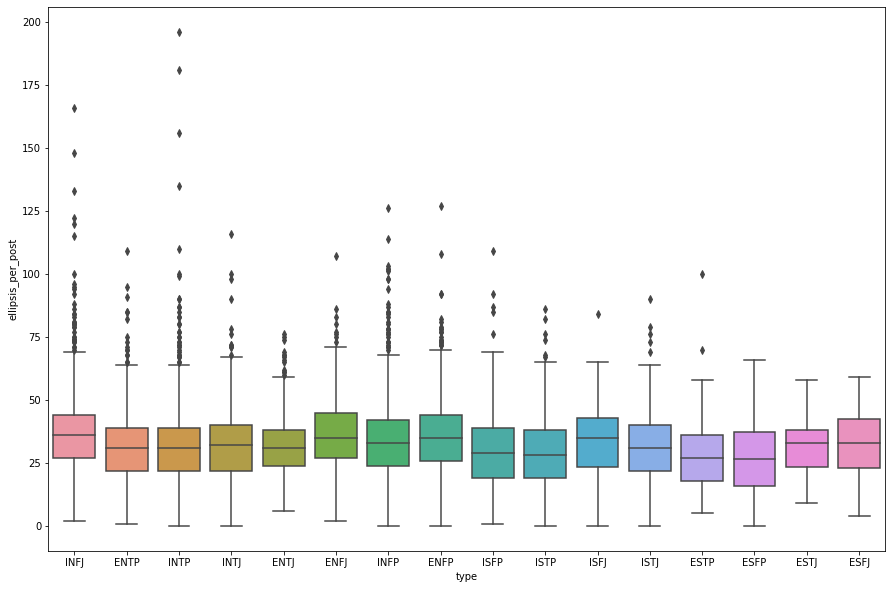

In [18]:
plt.figure(figsize=(15,10))
sns.boxplot("type", "ellipsis_per_post", data=df)

In [19]:
df[['type','img_per_post']].groupby('type').mean().sort_values(by='img_per_post', ascending=False)

img_per_post
type              
ESTP      0.876404
INTP      0.786043
INFP      0.776747
INTJ      0.735105
ISFP      0.730627
ISTP      0.700297
ISFJ      0.698795
ISTJ      0.668293
ENTJ      0.649351
ENTP      0.636496
INFJ      0.628571
ESFP      0.625000
ESTJ      0.615385
ENFJ      0.578947
ENFP      0.527407
ESFJ      0.333333

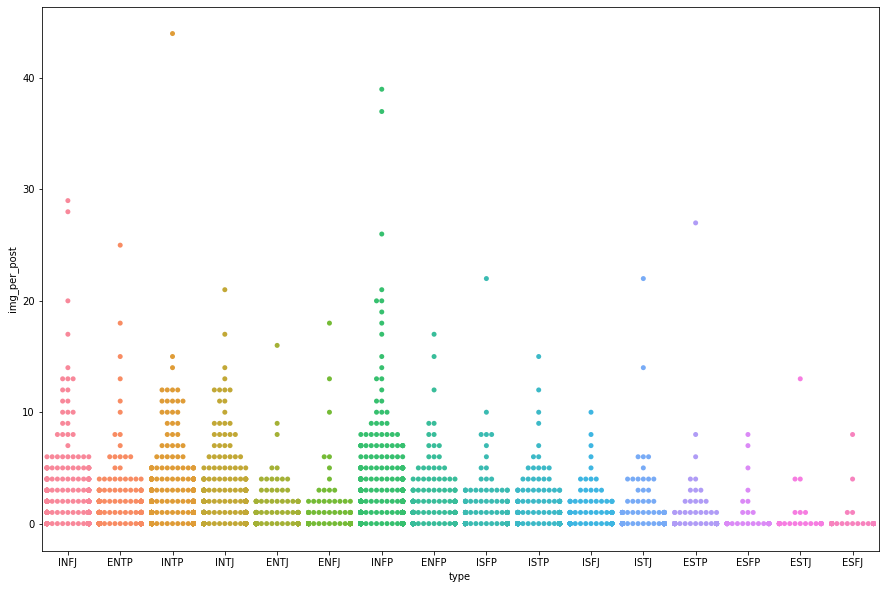

In [18]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "img_per_post", data=df)

## Preprocess the Data

In [20]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [21]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS

In [22]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def combine_text(text):
    return ' '.join(text)

def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer("[\w']+")
    no_punc = clean_text(text)
    tokenized_text = tokenizer.tokenize(no_punc)
    remove_stopwords = [w for w in tokenized_text if w not in STOPWORDS]
    combined_text = combine_text(remove_stopwords)
    
    return combined_text

In [23]:
df['clean_posts'] = df['posts'].apply(lambda x: text_preprocessing(x))

In [25]:
print(df['posts'][:10])

0    'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1    'I'm finding the lack of me in these posts ver...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You're fired.|||That's another silly misconce...
5    '18/37 @.@|||Science  is not perfect. No scien...
6    'No, I can't draw on my own nails (haha). Thos...
7    'I tend to build up a collection of things on ...
8    I'm not sure, that's a good question. The dist...
9    'https://www.youtube.com/watch?v=w8-egj0y8Qs||...
Name: posts, dtype: object


In [26]:
print(df['clean_posts'][:10])

0    ' intj moments sportscenter top ten plays pran...
1    'i'm finding lack posts alarming sex boring po...
2    'good one _____ course say know blessing curse...
3    'dear intp enjoyed conversation day esoteric g...
4    'you're fired another silly misconception appr...
5    ' science perfect scientist claims scientific ...
6    'no draw nails haha done professionals nails y...
7    'i tend build collection things desktop use fr...
8    sure good question distinction two dependant p...
9    ' position actually let go person due various ...
Name: clean_posts, dtype: object


In [27]:
def create_corpus(df):
    corpus = []
    for text in df.clean_posts.str.split():
        for i in text:
            corpus.append(i)
    return corpus

In [28]:
corpus = create_corpus(df)
corpus = nltk.FreqDist(corpus)

In [29]:
print('Total number of words:{}'.format(len(corpus)))
print('Most common words:{}'.format(corpus.most_common(20)))

Total number of words:106794
Most common words:[('think', 49346), ('people', 46217), ('know', 36436), ('one', 36076), ('really', 34895), ('time', 27258), ('feel', 23068), ('much', 22835), ('well', 22565), ('love', 20693), ('good', 20427), ('things', 20273), ('say', 20064), ('way', 19440), ('something', 19258), ('want', 19191), ('see', 18914), ('will', 18643), ('type', 16872), ('now', 16795)]


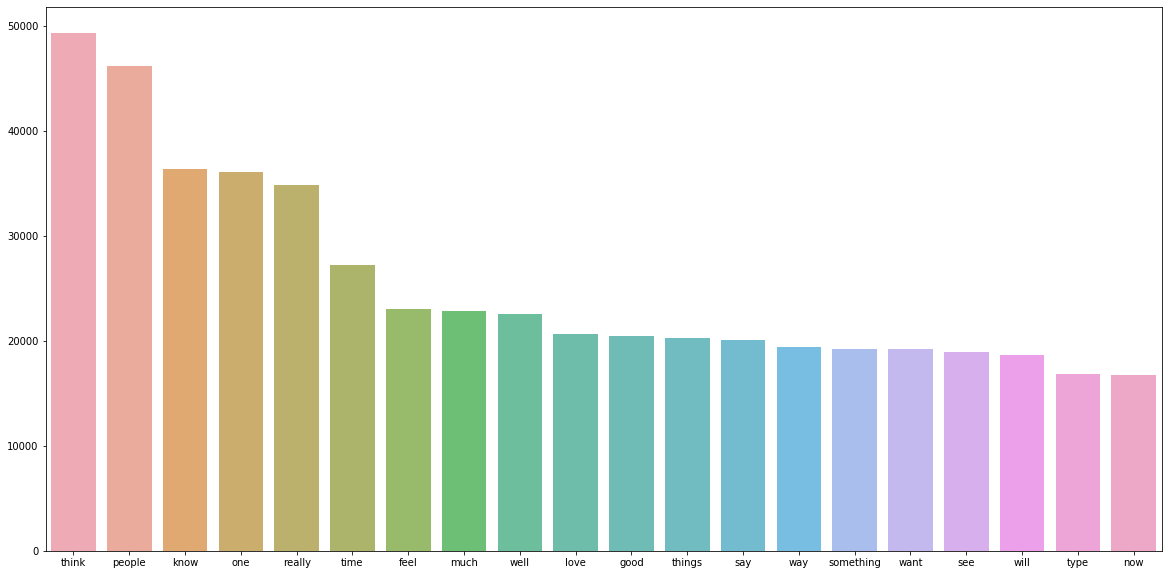

In [30]:
corpus_most_common = corpus.most_common(20)
x = [t[0] for t in corpus_most_common]
y = [t[1] for t in corpus_most_common]
plt.figure(figsize=(20,10))
sns.barplot(x, y, alpha=0.8)

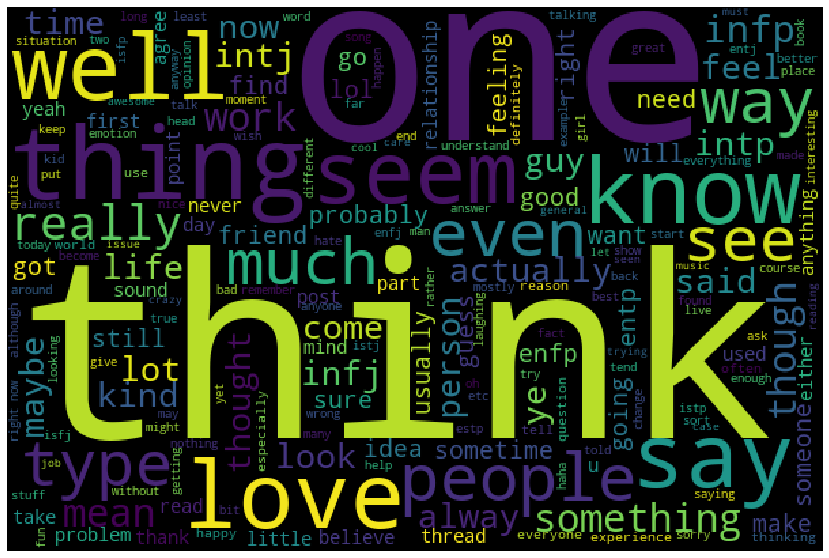

In [31]:
wordcloud = WordCloud(background_color = 'black' , width = 600 , height = 400).generate(" ".join(df['clean_posts']))

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [32]:
def category_top20(df,category):
    dx = df[df.type == category]
    corpus = create_corpus(dx)
    corpus = nltk.FreqDist(corpus)
    corpus_top20 = corpus.most_common(20)
    x = [t[0] for t in corpus_top20]
    y = [t[1] for t in corpus_top20]
    plt.figure(figsize = (15,5))
    sns.barplot(list(x) , list(y)).set(title = 'Frequency of Top 20 words in this '+ category)

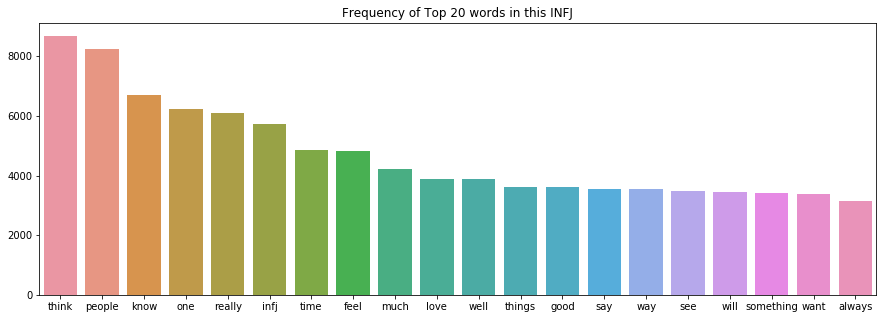

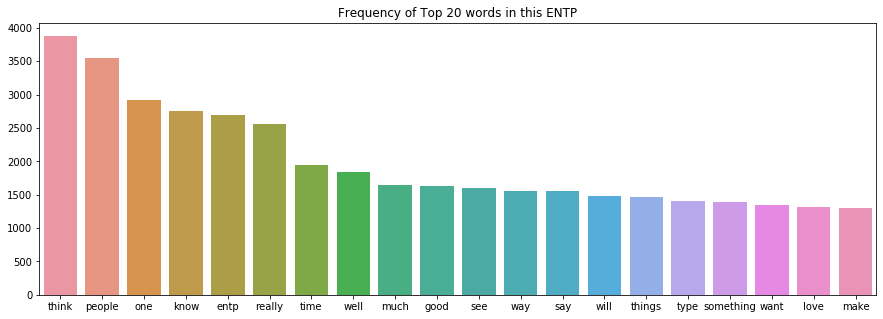

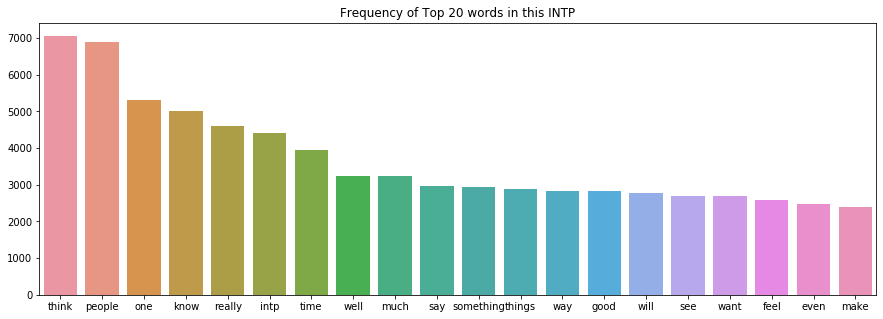

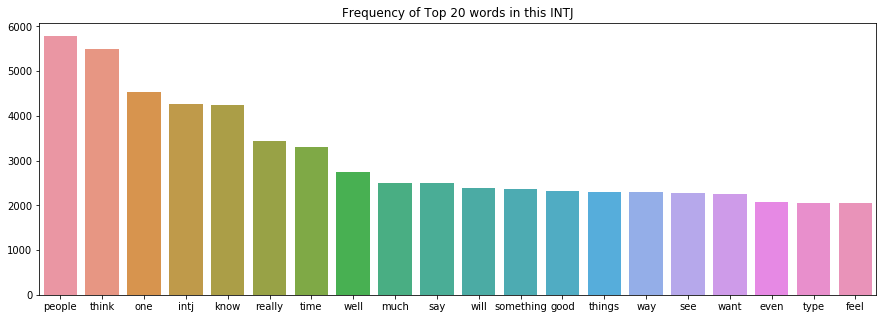

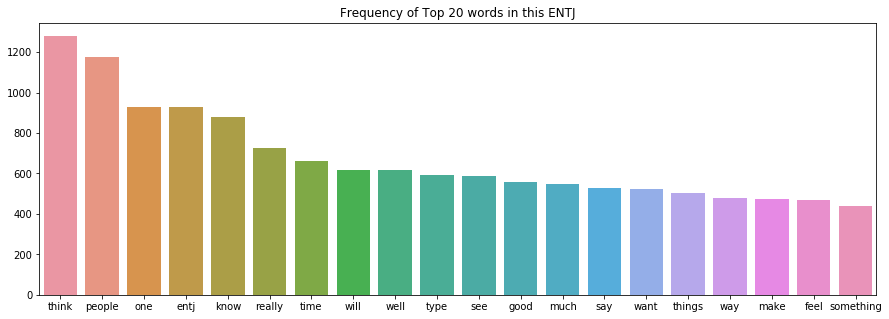

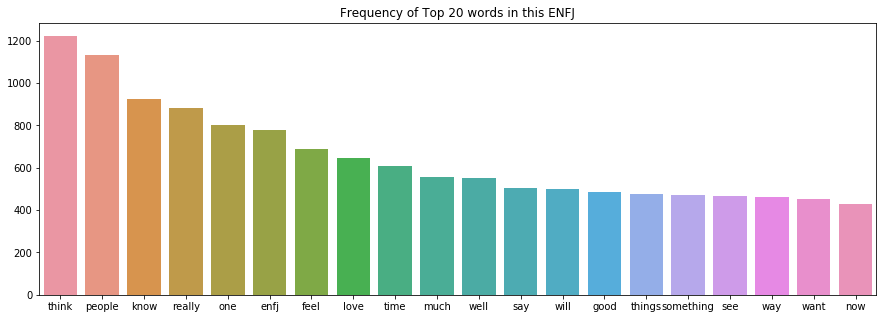

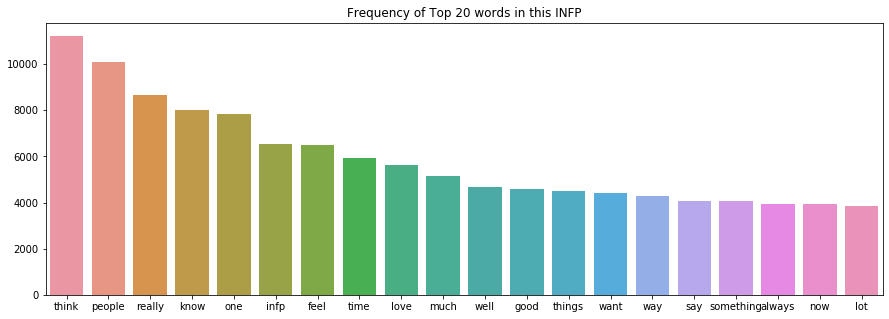

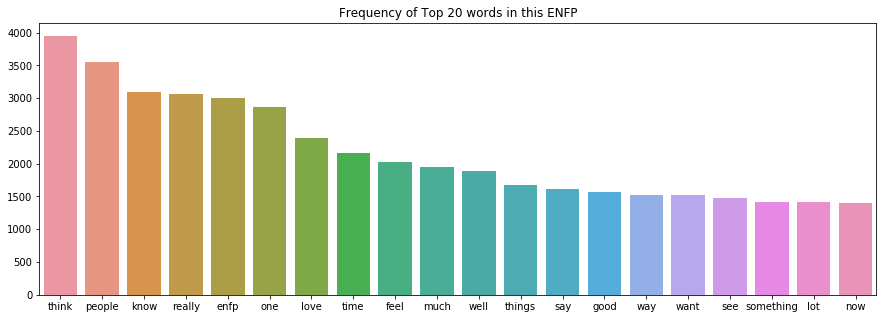

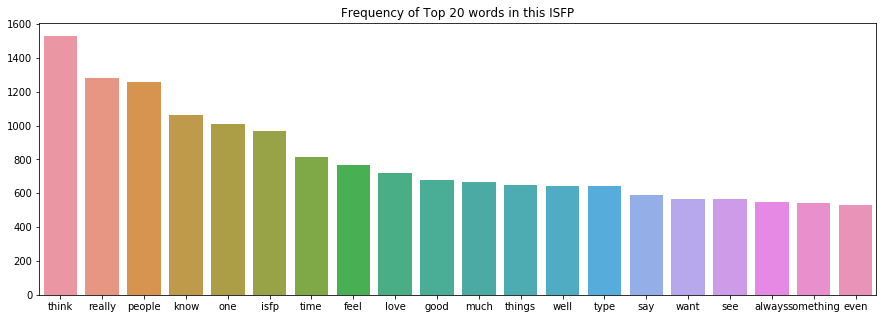

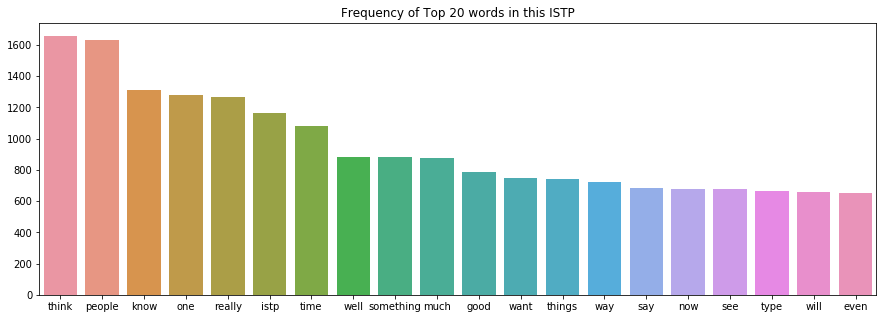

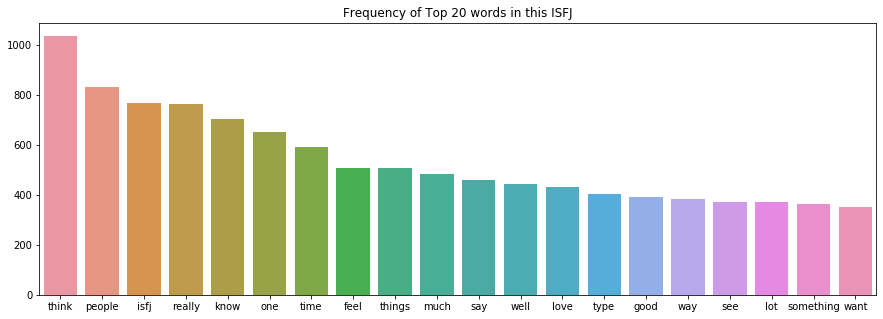

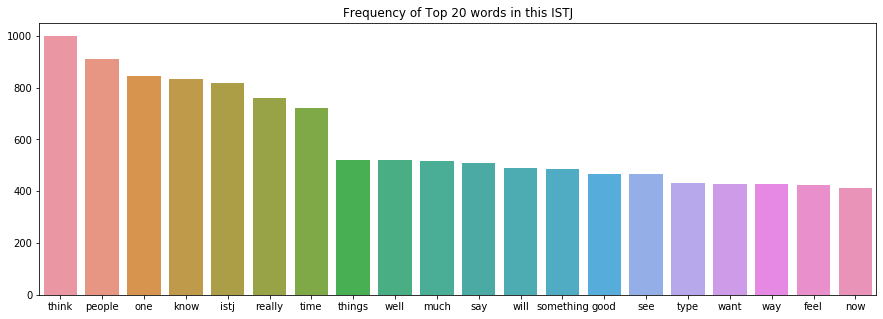

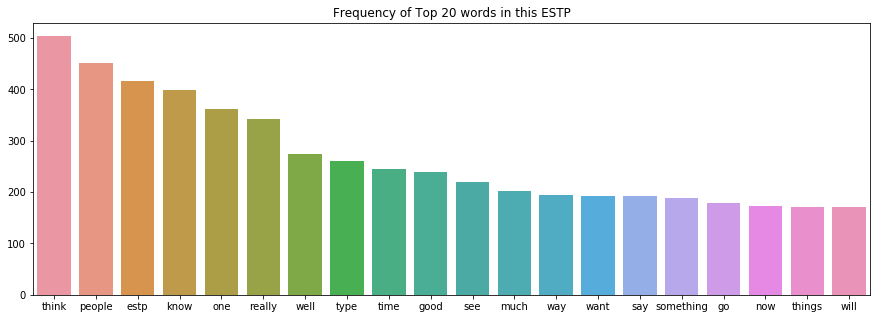

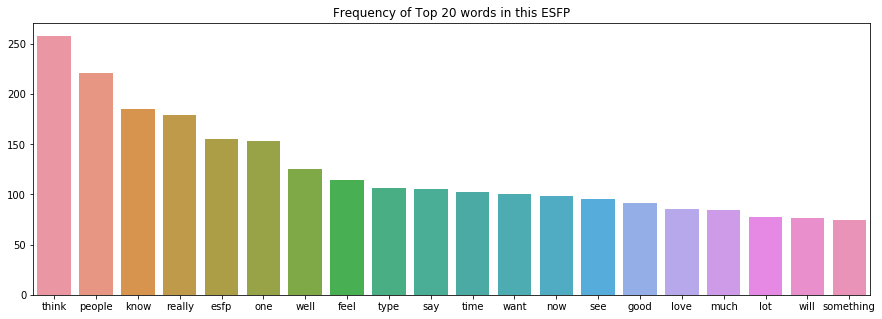

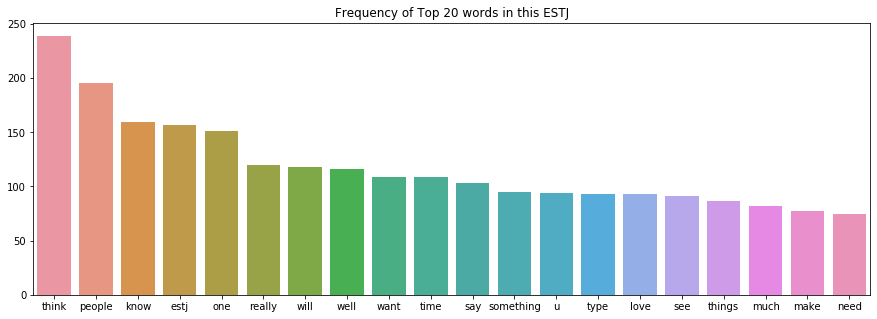

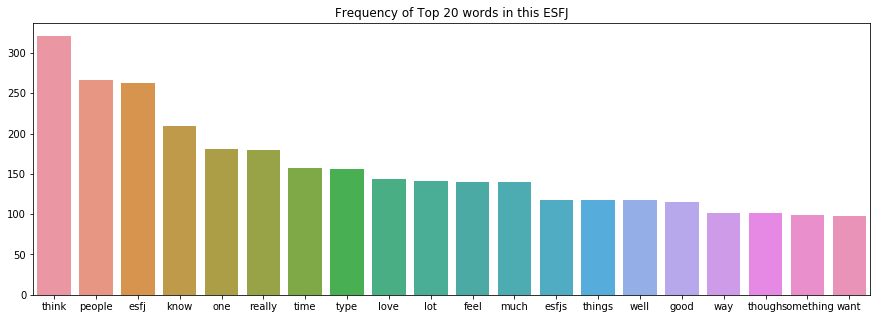

In [33]:
categories = df.type.unique()
for i in categories:
    category_top20(df,i)

In [34]:
def Word_Cloud(df, category):
    fig , ax1 = plt.subplots(1 , 1 , figsize = [10,8])
    dx = df[df.type == category]['clean_posts']
    wordcloud1 = WordCloud(background_color = 'black' , width = 600 , height = 400).generate(" ".join(dx))
    ax1.imshow(wordcloud1)
    ax1.axis('off')
    ax1.set_title('Wordcloud for posts '+ category , fontsize = 20)

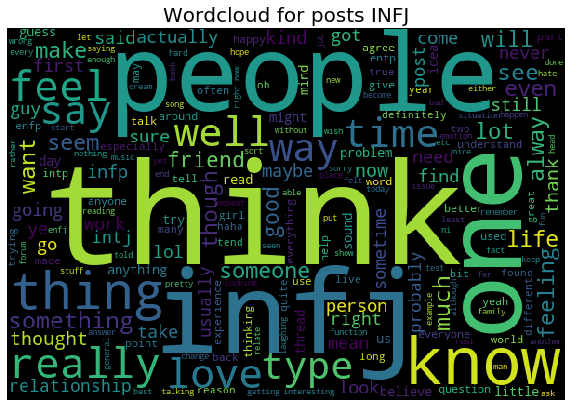

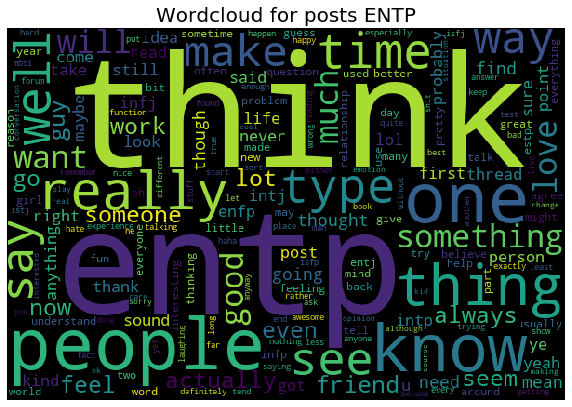

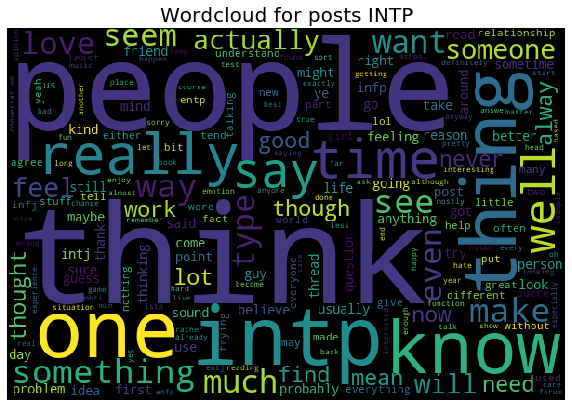

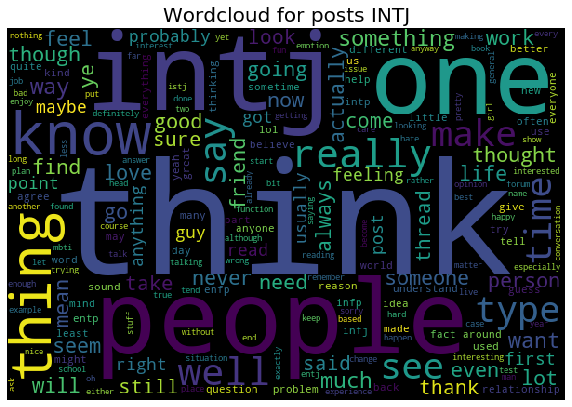

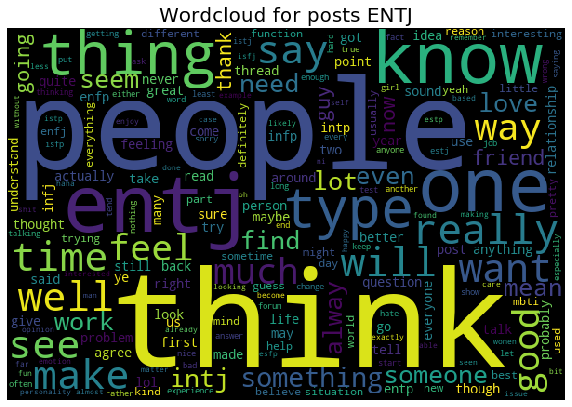

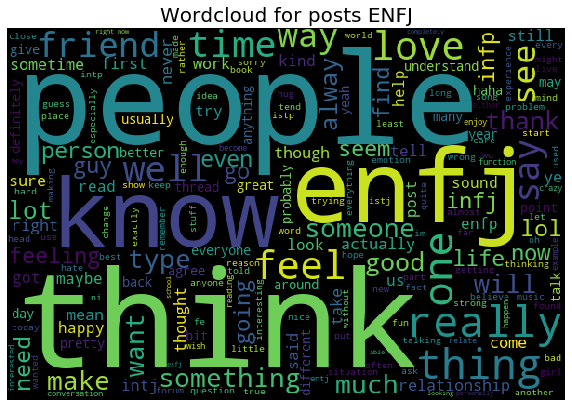

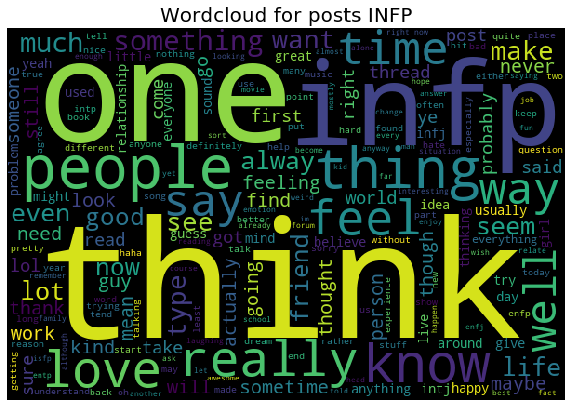

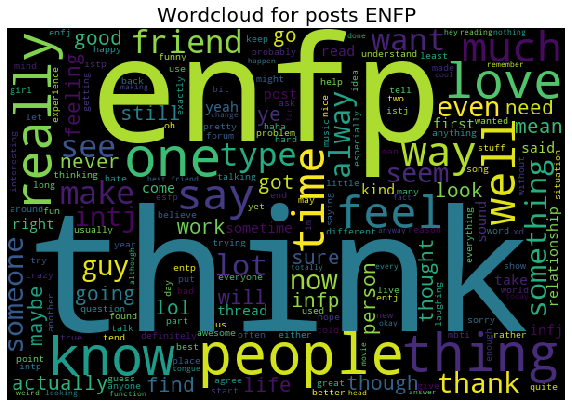

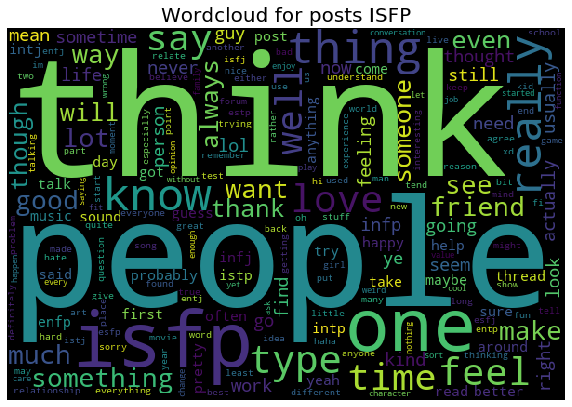

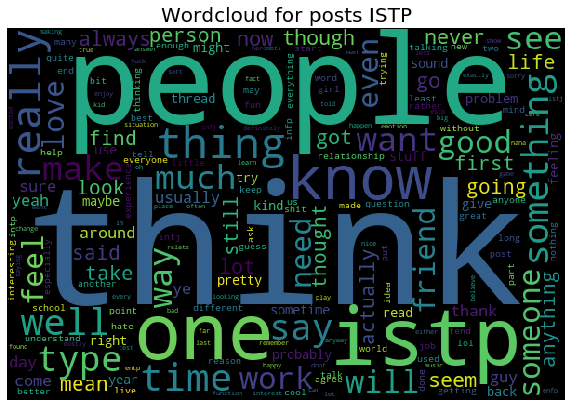

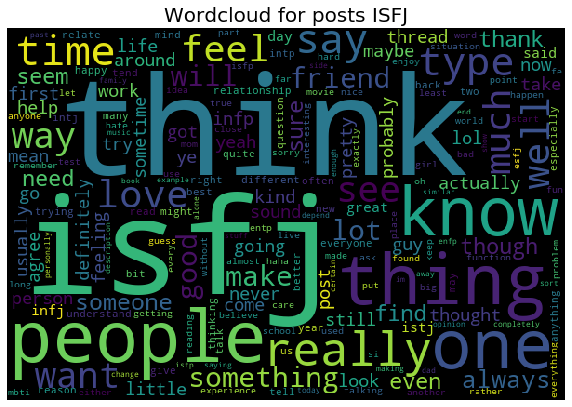

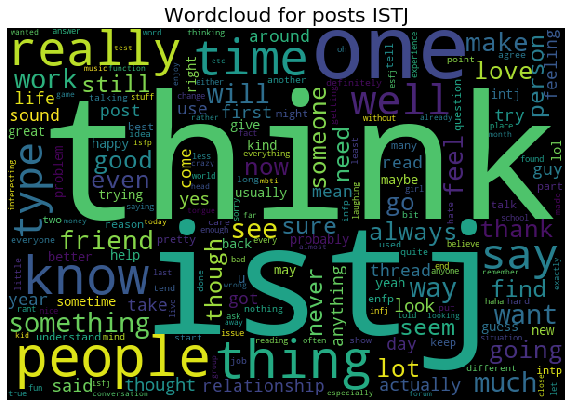

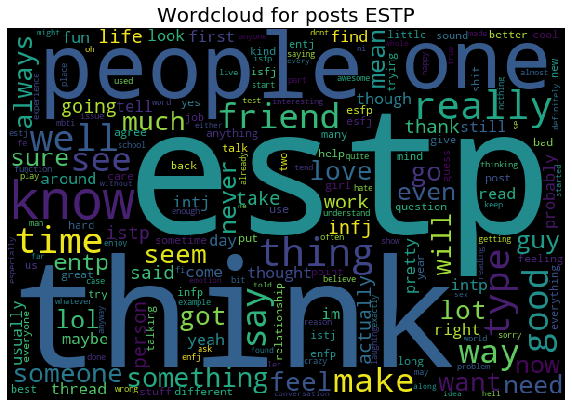

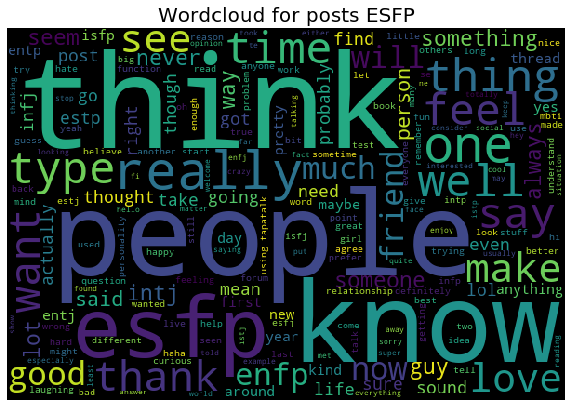

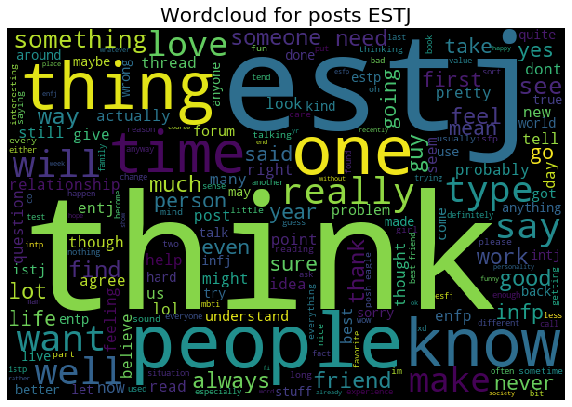

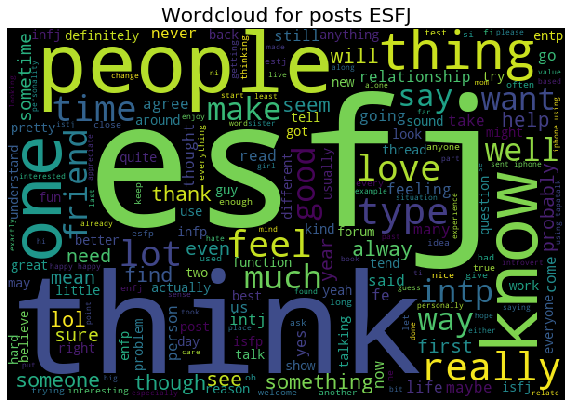

In [35]:
for i in categories:
    Word_Cloud(df,i)

## Machine Learning Models

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_posts'],df['type'],test_size=0.25,random_state=53)

In [41]:
count_vectorizer = CountVectorizer( min_df=0.1, max_df=0.9)
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [43]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(kernel='linear'),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Stochastic Gradient Descent": SGDClassifier(),
    "Naive Bayes": MultinomialNB()
}

In [44]:
for name, model in classifiers.items():
    model.fit(count_train,y_train)
    accuracy = accuracy_score(y_test,model.predict(count_test))
    print('{} Accuracy: {}'.format(name,accuracy))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisiticRegression Accuracy: 0.541263254956201
KNearest Accuracy: 0.36053480866758875
Support Vector Classifier Accuracy: 0.5601659751037344
DecisionTreeClassifier Accuracy: 0.4661134163208852
Random Forest Classifier Accuracy: 0.5887505763024435
Stochastic Gradient Descent Accuracy: 0.5269709543568465
Naive Bayes Accuracy: 0.6021207929921623


In [45]:
from numpy import arange
min_df_sets = arange(0.01,.2,0.01)
Accuracy_sets=[]
for n in min_df_sets:
    count_vectorizer = CountVectorizer( min_df=n, max_df=1-n)
    count_train = count_vectorizer.fit_transform(X_train.values)
    count_test = count_vectorizer.transform(X_test.values)
    nb_classifier = MultinomialNB()
    nb_classifier.fit(count_train,y_train)
    Accuracy = accuracy_score(y_test,nb_classifier.predict(count_test))
    Accuracy_sets.append(Accuracy)

<function matplotlib.pyplot.show(*args, **kw)>

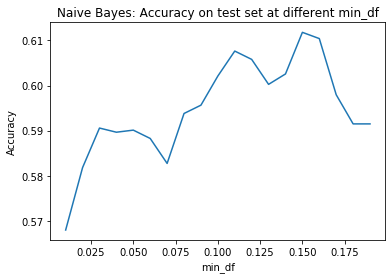

In [46]:
plt.plot(min_df_sets,Accuracy_sets)
plt.xlabel("min_df")
plt.ylabel("Accuracy")
plt.title("Naive Bayes: Accuracy on test set at different min_df")
plt.show

In [47]:
print(Accuracy_sets)

[0.5680036883356385, 0.5818349469801752, 0.5905947441217151, 0.5896726602120793, 0.5901337021668972, 0.5882895343476257, 0.582757030889811, 0.5938220378054403, 0.5956662056247118, 0.6021207929921623, 0.6076532964499769, 0.6058091286307054, 0.6002766251728907, 0.6025818349469801, 0.611802674043338, 0.6104195481788843, 0.5979714153988013, 0.5915168280313509, 0.5915168280313509]


The highest accuracy is 0.612 when we only consider words appear in more than 15% and less than 85% of the posts.

In [48]:
# Best model
count_vectorizer_best = CountVectorizer( min_df=0.15, max_df=0.85)
count_train_best = count_vectorizer_best.fit_transform(X_train.values)
count_test_best = count_vectorizer_best.transform(X_test.values)
nb_classifier_best = MultinomialNB()
nb_classifier_best.fit(count_train_best,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Predict Personality of Kaggle Users

In [49]:
kaggle = pd.read_csv('/Users/vnguyenair/Desktop/springboard/vy_capstone2_Personality_Prediction/ForumMessages.csv')

In [50]:
kaggle.head()

Id  ForumTopicId  PostUserId             PostDate  ReplyToForumMessageId  \
0  14             7         478  05/02/2010 14:37:35                    NaN   
1  15             8         638  05/04/2010 09:32:54                    NaN   
2  16             8         650  05/04/2010 09:32:54                    NaN   
3  17             8         478  05/04/2010 09:32:54                    NaN   
4  28            16         368  05/12/2010 04:39:30                    NaN   

                                             Message  Medal MedalAwardDate  
0  Now that we have a handful of algorithms that ...    NaN            NaN  
1  The goal of the game is to answer the question...    NaN            NaN  
2  Look at the description in the Data section:<b...    NaN            NaN  
3  <blockquote><p>The dataset contains many diffe...    NaN            NaN  
4  Here are some papers that analyze Eurovision v...    NaN            NaN

In [51]:
kaggle['Message'] = kaggle['Message'].fillna('')

In [53]:
kaggle_join = kaggle.groupby('PostUserId')['Message'].agg(lambda col: ' '.join(col)).reset_index()

In [54]:
kaggle_join.head()

PostUserId                                            Message
0          62  Vateesh, thanks for alerting us to this. Can y...
1         368  Here are some papers that analyze Eurovision v...
2         381  <p>Hi Bdol.</p>\r\n<p>Please comment out the l...
3         387  <p>From an economic perspective let's look at ...
4         389  <pre><code>import bokeh\nfrom bokeh.plotting i...

In [55]:
kaggle_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141963 entries, 0 to 141962
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PostUserId  141963 non-null  int64 
 1   Message     141963 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.2+ MB


In [56]:
kaggle_join['Message_length']= kaggle_join['Message'].apply(lambda x: len(x.split()))

In [61]:
kaggle_join_len = kaggle_join.loc[kaggle_join.Message_length > 500,:]

In [62]:
kaggle_join_len.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9235 entries, 1 to 141870
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   PostUserId      9235 non-null   int64 
 1   Message         9235 non-null   object
 2   Message_length  9235 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 288.6+ KB


In [63]:
kaggle_join_len['clean_messages'] = kaggle_join_len['Message'].apply(lambda x: text_preprocessing(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [64]:
kaggle_join_len.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9235 entries, 1 to 141870
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   PostUserId      9235 non-null   int64 
 1   Message         9235 non-null   object
 2   Message_length  9235 non-null   int64 
 3   clean_messages  9235 non-null   object
dtypes: int64(2), object(2)
memory usage: 360.7+ KB


In [65]:
count_kaggle = count_vectorizer_best.transform(kaggle_join_len['clean_messages'].values)
pred_kaggle = nb_classifier_best.predict(count_kaggle)
count_all = np.unique(pred_kaggle, return_counts=True)
print(count_all)

(array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype='<U4'), array([ 261,  271,  608,   11,   30,  564,  754,    3,  263,   83, 3934,
        734,    8,   16, 1175,  520]))


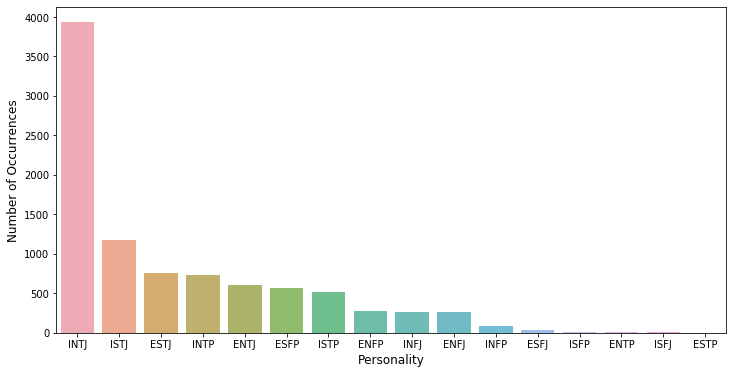

In [68]:

pred_df = pd.DataFrame({'personality': count_all[0], 'count': count_all[1]},
                      columns=['personality', 'count'], index=None)
pred_df.sort_values('count', ascending=False, inplace=True)

plt.figure(figsize=(12,6))
sns.barplot(pred_df['personality'], pred_df['count'], alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Personality', fontsize=12)
plt.show()

## Predict Personality of Popular People

In [74]:
social_posts = pd.read_excel('/Users/vnguyenair/Desktop/springboard/vy_capstone2_Personality_Prediction/Social_Posts.xlsx')

In [75]:
social_posts.head()

Name                                              Posts
0  Barack Obama  Michelle and I have been spending a lot of tim...
1  Donald Trump   My visits last week to Texas and Florida had ...

In [76]:
social_posts['posts_length']=social_posts['Posts'].apply(lambda x: len(x.split()))

In [77]:
social_posts.head()

Name                                              Posts  \
0  Barack Obama  Michelle and I have been spending a lot of tim...   
1  Donald Trump   My visits last week to Texas and Florida had ...   

   posts_length  
0           766  
1           598

In [79]:
social_posts['clean_posts'] = social_posts['Posts'].apply(lambda x: text_preprocessing(x))

In [80]:
count_train_best = count_vectorizer_best.fit_transform(X_train.values)
count_exam = count_vectorizer_best.transform(social_posts['clean_posts'].values)

In [81]:
nb_classifier_best.predict(count_exam)

array(['INFP', 'INFP'], dtype='<U4')